In [46]:
import keras
import tqdm
from sklearn.model_selection import LeaveOneOut, KFold
from pydotplus import graphviz
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
from keras import models
from keras.models import Sequential, Model
from keras.losses import binary_crossentropy
from tensorflow.keras.utils  import plot_model
from keras import layers
from keras.layers import Dense, Input, concatenate
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [47]:
!pip install keras-rectified-adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
from keras_radam import RAdam

In [49]:
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [50]:
df = pd.read_csv('https://raw.githubusercontent.com/diunkz/UFAM-IA/main/trains-transformed.csv')
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,long,openrect,3,rectanglod,2,short,slopetop,...,1,0,0,0,1,0,0,1,0,east
1,4,3,2,short,ushaped,1,trianglod,2,short,opentrap,...,1,0,1,0,0,0,0,0,0,east
2,4,2,2,short,openrect,1,circlelod,2,short,hexagon,...,0,0,0,1,0,1,0,0,0,east
3,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,...,1,0,0,1,0,0,0,0,0,east
4,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,...,1,0,1,0,0,0,0,0,0,east
5,3,2,2,long,closedrect,3,circlelod,2,short,openrect,...,0,0,0,0,0,1,0,0,0,west
6,4,2,2,short,dblopnrect,1,circlelod,2,short,ushaped,...,0,0,0,0,0,1,0,0,0,west
7,3,2,3,long,closedrect,1,rectanglod,2,short,ushaped,...,0,0,1,0,0,0,0,0,0,west
8,5,2,2,short,opentrap,1,circlelod,2,long,jaggedtop,...,0,0,1,0,0,0,0,0,0,west
9,3,1,2,short,ushaped,1,rectanglod,2,long,openrect,...,0,0,0,0,0,0,0,0,0,west


In [51]:
#realizando as modificações da base 
str_att = {
  'length': ['short', 'long'],
  'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
          'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
  'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
  'Class_attribute': ['west','east']
}

def read_data(df):

  for k in df:
    for att in str_att:
      if k.startswith(att):
        for i,val in enumerate(df[k]):
          if val in str_att[att]:
            df[k][i] = str_att[att].index(val)

  df.replace("\\0", 0, inplace=True)
  df.replace("None", -1, inplace=True)

  return df

In [52]:
#base apos modificações
df = read_data(df)
df

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,...,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,...,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,...,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,...,1,0,0,1,0,0,0,0,0,1
4,4,3,2,0,1,1,3,3,1,0,...,1,0,1,0,0,0,0,0,0,1
5,3,2,2,1,0,3,0,2,0,6,...,0,0,0,0,0,1,0,0,0,0
6,4,2,2,0,1,1,0,2,0,9,...,0,0,0,0,0,1,0,0,0,0
7,3,2,3,1,0,1,2,2,0,9,...,0,0,1,0,0,0,0,0,0,0
8,5,2,2,0,7,1,0,2,1,5,...,0,0,1,0,0,0,0,0,0,0
9,3,1,2,0,9,1,2,2,1,6,...,0,0,0,0,0,0,0,0,0,0


## Questão 1

### Implemente uma solução que implemente proposicionalização com 32 neurônios
###de entrada e uma única saída (denotando leste).

In [53]:
y_train = df['Class_attribute']

X_train = df.drop('Class_attribute', axis=1)

In [54]:
y_train

0    1
1    1
2    1
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: Class_attribute, dtype: int64

In [55]:
#Necessario realizar o reshape para que o objeto possa ser transposto para tensor
x = np.asarray(X_train).astype('float32')

In [56]:
x

array([[ 5.,  4.,  2.,  1.,  6.,  3.,  2.,  2.,  0.,  8.,  1.,  3.,  3.,
         1.,  6.,  1.,  1.,  2.,  0.,  6.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  3.,  2.,  0.,  9.,  1.,  3.,  2.,  0.,  7.,  1.,  2.,  2.,
         0.,  0.,  2.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  2.,  2.,  0.,  6.,  1.,  0.,  2.,  0.,  4.,  1.,  3.,  3.,
         1.,  0.,  1.,  3., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  2.,  0.,  7.,  1.,  3.,  2.,  0.,  1.,  1.,  3.,  2.,
         0.,  2.,  1.,  2.,  2.,  0.,  6.,  1.,  2.,  1.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  0.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,  2.,  2.,
         0.,  0.,  1.,  0., -1., -1., -1., -1., -1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  1.,  0.,  3.,  0.,  2.,  0.,  6.,  1.,  3., -1.,
  

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y_train, test_size=0.2,random_state=42)

In [58]:
#criando modelo de rede neural simples
network = models.Sequential()
network.add(layers.Dense(36, activation='relu', input_shape=(32,)))
network.add(layers.Dense(1, activation='sigmoid'))
network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 36)                1188      
                                                                 
 dense_5 (Dense)             (None, 1)                 37        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


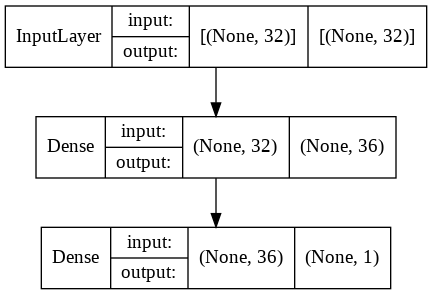

In [59]:
plot_model(network, show_shapes=True, show_layer_names=False)

In [60]:
network.compile(optimizer= 'adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy','mse','Recall','Precision','AUC'])
H = network.fit(X_train, Y_train, epochs=50,validation_data =(X_test,Y_test),batch_size=1)

Epoch 1/50
8/8 [==============================] - 2s 71ms/step - loss: 1.6496 - accuracy: 0.5000 - mse: 0.4368 - recall: 1.0000 - precision: 0.5000 - auc: 0.3750 - val_loss: 0.7692 - val_accuracy: 0.5000 - val_mse: 0.3072 - val_recall: 1.0000 - val_precision: 0.5000 - val_auc: 1.0000
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 1.2937 - accuracy: 0.5000 - mse: 0.3863 - recall: 1.0000 - precision: 0.5000 - auc: 0.5000 - val_loss: 0.7703 - val_accuracy: 0.5000 - val_mse: 0.3069 - val_recall: 1.0000 - val_precision: 0.5000 - val_auc: 1.0000
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 1.0240 - accuracy: 0.6250 - mse: 0.3250 - recall: 1.0000 - precision: 0.5714 - auc: 0.7188 - val_loss: 0.7646 - val_accuracy: 0.5000 - val_mse: 0.3037 - val_recall: 1.0000 - val_precision: 0.5000 - val_auc: 1.0000
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8416 - accuracy: 0.6250 - mse: 0.2800 - recall: 1.0000 - precision: 0.5714 

In [61]:
history_dict = H.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'mse', 'recall', 'precision', 'auc', 'val_loss', 'val_accuracy', 'val_mse', 'val_recall', 'val_precision', 'val_auc'])

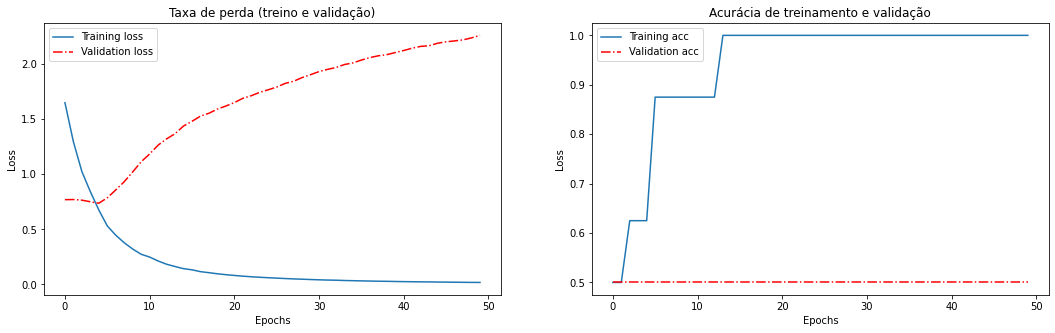

In [63]:
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(0, 50)
loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, '-.r', label='Validation loss')
plt.title('Taxa de perda (treino e validação)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, '-.r', label='Validation acc')
plt.title('Acurácia de treinamento e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Questão 2

### Implemente uma solução com base no modelo de aprendizado relacional contendo meta-redes para conectar conceitos das premissas. Este modelos deve conter 11 redes, uma para cada um dos seguintes conceitos conforme definição das paginas 136 e 137:

In [64]:
def model_v2():
  # features
  t   = Input(shape=(1,), name='t')
  c   = Input(shape=(1,), name='c') 
  w   = Input(shape=(1,), name='w')
  l   = Input(shape=(1,), name='l')
  s   = Input(shape=(1,), name='s')
  nc  = Input(shape=(1,), name='nc')
  ls  = Input(shape=(1,), name='ls')
  nl  = Input(shape=(1,), name='nl')
  ncl = Input(shape=(1,), name='ncl')
  x_crc = Input(shape=(1,), name='x_crc')
  x_hex = Input(shape=(1,), name='x_hex')
  x_rec = Input(shape=(1,), name='x_rec')
  x_tri = Input(shape=(1,), name='x_tri')

  # num_cars(t,nc)
  num_cars_ = concatenate([t,nc])
  num_cars_ = Dense(20, activation='relu')(num_cars_)
  num_cars = Dense(1, activation='sigmoid', name='num_cars')(num_cars_)
  num_cars = Model(inputs=[t,nc], outputs=num_cars)

  # num_loads(t,nl)
  num_loads_ = concatenate([t,nl])
  num_loads_ = Dense(20, activation='relu')(num_loads_)
  num_loads = Dense(1, activation='sigmoid', name='num_loads')(num_loads_)
  num_loads = Model(inputs=[t,nl], outputs=num_loads)

  # num_wheels(t,c,w)
  num_wheels_ = concatenate([t,c,w])
  num_wheels_ = Dense(20, activation='relu')(num_wheels_)
  num_wheels = Dense(1, activation='sigmoid', name='num_wheels')(num_wheels_)
  num_wheels = Model(inputs=[t,c,w], outputs=num_wheels)

  # length(t,c,l)
  length_ = concatenate([t,c,l])
  length_ = Dense(20, activation='relu')(length_)
  length = Dense(1, activation='sigmoid', name='length')(length_)
  length = Model(inputs=[t,c,l], outputs=length)

  # shape(t,c,s)
  shape_ = concatenate([t,c,s])
  shape_ = Dense(20, activation='relu')(shape_)
  shape = Dense(1, activation='sigmoid', name='shape')(shape_)
  shape = Model(inputs=[t,c,s], outputs=shape)

  # num_car_loads(t,c,ncl)
  num_car_loads_ = concatenate([t,c,ncl])
  num_car_loads_ = Dense(20, activation='relu')(num_car_loads_)
  num_car_loads = Dense(1, activation='sigmoid', name='num_car_loads')(num_car_loads_)
  num_car_loads = Model(inputs=[t,c,ncl], outputs=num_car_loads)

  # load_shape(t,c,ls)
  load_shape_ = concatenate([t,c,ls])
  load_shape_ = Dense(20, activation='relu')(load_shape_)
  load_shape = Dense(1, activation='sigmoid', name='load_shape')(load_shape_)
  load_shape = Model(inputs=[t,c,ls], outputs=load_shape)

  # next_crc(t,c,x)
  next_crc_ = concatenate([t,c,x_crc])
  next_crc_ = Dense(20, activation='relu')(next_crc_)
  next_crc = Dense(1, activation='sigmoid', name='next_crc')(next_crc_)
  next_crc = Model(inputs=[t,c,x_crc], outputs=next_crc)

  # next_hex_(t,c,x)
  next_hex_ = concatenate([t,c,x_hex])
  next_hex_ = Dense(20, activation='relu')(next_hex_)
  next_hex = Dense(1, activation='sigmoid', name='next_hex')(next_hex_)
  next_hex = Model(inputs=[t,c,x_hex], outputs=next_hex)

  # next_rec(t,c,x)
  next_rec_ = concatenate([t,c,x_rec])
  next_rec_ = Dense(20, activation='relu')(next_rec_)
  next_rec = Dense(1, activation='sigmoid', name='next_rec')(next_rec_)
  next_rec = Model(inputs=[t,c,x_rec], outputs=next_rec)

  # next_tri(t,c,x)
  next_tri_ = concatenate([t,c,x_tri])
  next_tri_ = Dense(20, activation='relu')(next_tri_)
  next_tri = Dense(1, activation='sigmoid', name='next_tri')(next_tri_)
  next_tri = Model(inputs=[t,c,x_tri], outputs=next_tri)

  # east
  east = concatenate([
    num_cars_, 
    num_loads_, 
    num_wheels_,
    length_,
    shape_,
    num_car_loads_,
    load_shape_,
    next_crc_,
    next_hex_,
    next_rec_,
    next_tri_
  ])
  east = Dense(3, activation='relu')(east)
  east =  Dense(1, activation='sigmoid', name='east')(east)
  east = Model(inputs=[t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri], outputs=east)
  
  # metanet
  metanet = Model(
    inputs=east.inputs, 
    outputs=[
      num_cars.output, 
      num_loads.output, 
      num_wheels.output,
      length.output,
      shape.output,
      num_car_loads.output,
      load_shape.output,
      next_crc.output,
      next_hex.output,
      next_rec.output,
      next_tri.output,
      east.output
  ])

  # rules
  rules = {
    'num_cars': num_cars, 
    'num_loads': num_loads, 
    'num_wheels': num_wheels,
    'length': length,
    'shape': shape,
    'num_car_loads': num_car_loads,
    'load_shape': load_shape,
    'next_crc': next_crc,
    'next_hex': next_hex,
    'next_rec': next_rec,
    'next_tri': next_tri,
  }

  return metanet, east, rules

metanet, east, rules = model_v2()
metanet.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 nc (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 nl (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 1)]          0           []                               
                                                                                           

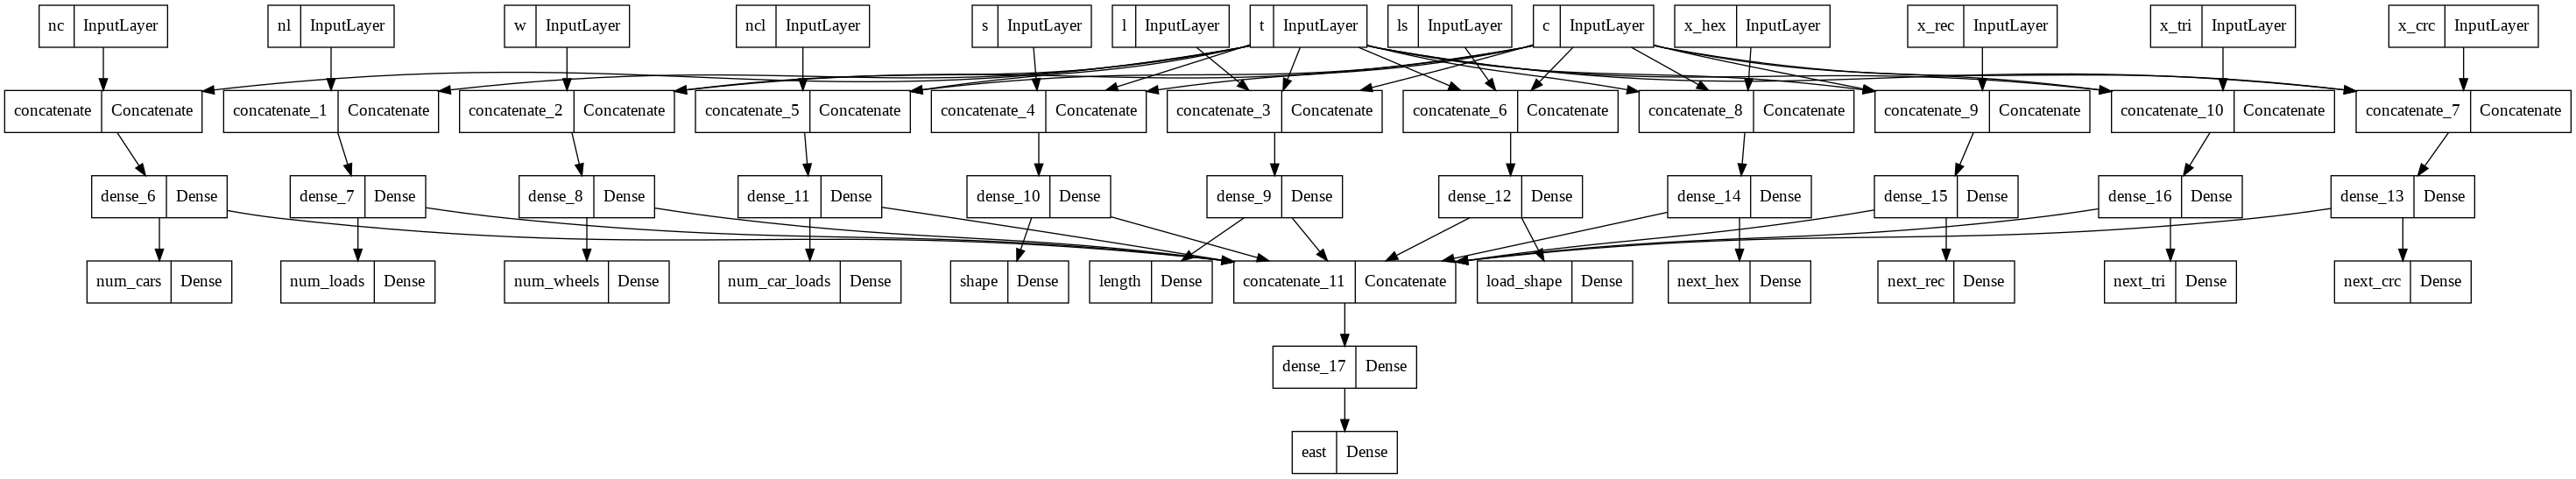

In [65]:
plot_model(metanet, show_shapes=False, show_layer_names=True)

In [66]:
# transform data
df = read_data(df)
cols = [[c for c in df.columns if not(str.isdigit(c[-1])) or (str.isdigit(c[-1]) and int(c[-1])==n)] for n in range(1,5)]

data = [df[col] for col in cols]
for c, df in enumerate(data):
  df.columns = [name if not str.isdigit(name[-1]) else name[:-1] for name in df.columns]
  df['car'] = c+1

data = pd.concat(data)
data.reset_index(level=0, inplace=True)
data['train'] = data.pop('index')
data.T[0]

Number_of_cars                 5
Number_of_different_loads      4
num_wheels                     2
length                         1
shape                          6
num_loads                      3
load_shape                     2
Rectangle_next_to_rectangle    0
Rectangle_next_to_triangle     1
Rectangle_next_to_hexagon      0
Rectangle_next_to_circle       0
Triangle_next_to_triangle      0
Triangle_next_to_hexagon       1
Triangle_next_to_circle        0
Hexagon_next_to_hexagon        0
Hexagon_next_to_circle         1
Circle_next_to_circle          0
Class_attribute                1
car                            1
train                          0
Name: 0, dtype: object

In [67]:
data

,Number_of_cars,Number_of_different_loads,num_wheels,length,shape,num_loads,load_shape,Rectangle_next_to_rectangle,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute,car,train
0,5,4,2,1,6,3,2,0,1,0,0,0,1,0,0,1,0,1,1,0
1,4,3,2,0,9,1,3,0,1,0,1,0,0,0,0,0,0,1,1,1
2,4,2,2,0,6,1,0,0,0,0,0,1,0,1,0,0,0,1,1,2
3,5,2,2,0,7,1,3,1,1,0,0,1,0,0,0,0,0,1,1,3
4,4,3,2,0,1,1,3,0,1,0,1,0,0,0,0,0,0,1,1,4
5,3,2,2,1,0,3,0,0,0,0,0,0,0,1,0,0,0,0,1,5
6,4,2,2,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,6
7,3,2,3,1,0,1,2,0,0,0,1,0,0,0,0,0,0,0,1,7
8,5,2,2,0,7,1,0,1,0,0,1,0,0,0,0,0,0,0,1,8
9,3,1,2,0,9,1,2,1,0,0,0,0,0,0,0,0,0,0,1,9
